In [1]:
import numpy as np 
import pandas as pd 
import os

In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten
from tensorflow.keras.layers import Conv2D,MaxPool2D
from tensorflow.keras.layers import Input, Dense
from keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [3]:
PATH = os.getcwd()
print(PATH)
PATH = 'data/natural_images'
data_dir_list = os.listdir(PATH)
print(data_dir_list)

C:\Users\souka\3D Objects
['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']


In [4]:
img_rows=224
img_cols=224
num_channel=3

num_epoch = 5
batch_size = 32

img_data_list=[]
classes_names_list=[]
target_column=[]

In [5]:
for dataset in data_dir_list:
    classes_names_list.append(dataset)
    print("Getting images from {} folder\n".format(dataset))
    img_list = os.listdir(PATH+'/'+ dataset)
    for img in img_list:
        input_img = cv2.imread(PATH + '/' + dataset + '/' + img)
        input_img_resize=cv2.resize(input_img,(img_rows,img_cols))
        img_data_list.append(input_img_resize)
        target_column.append(dataset)

Getting images from airplane folder

Getting images from car folder

Getting images from cat folder

Getting images from dog folder

Getting images from flower folder

Getting images from fruit folder

Getting images from motorbike folder

Getting images from person folder



In [6]:
num_classes = len(classes_names_list)
print(num_classes)

8


#### Image Pre-Processing

In [7]:
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data /= 255
print(img_data.shape)

(6899, 224, 224, 3)


In [8]:
num_of_samples = img_data.shape[0]
input_shape = img_data[0].shape

In [9]:
Labelencoder = LabelEncoder()
target_column = Labelencoder.fit_transform(target_column)
np.unique(target_column)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [10]:
 target_column_hotcoded = to_categorical(target_column,num_classes)
X,Y = shuffle(img_data,target_column_hotcoded,random_state=2)
X_train,X_temp,y_train,y_temp = train_test_split(X,Y,test_size=0.3,random_state=2)
X_test,X_val,y_test,y_val = train_test_split(X_temp,y_temp,test_size=0.3,random_state=2)

#### Transfert d'apprentissage VGG NET



In [11]:
image_input = Input(shape=(img_rows,img_cols,num_channel))
vgg_mod = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')
vgg_mod.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
last_layer = vgg_mod.get_layer('fc2').output
out = Dense(num_classes,activation='softmax',name='output')(last_layer)

In [13]:
cust_vgg_model = Model(image_input,out)
cust_vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
#compiler le modèle
for layer in cust_vgg_model.layers[:-1]:
    layer.trainable = False
cust_vgg_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=["accuracy"])

In [15]:
hist_1=cust_vgg_model.fit(X_train,y_train,batch_size=batch_size,epochs=5,verbose=1,validation_data=(X_test, y_test))

Epoch 1/5
151/151 [==============================] - 1367s 9s/step - loss: 0.9830 - accuracy: 0.7059 - val_loss: 0.1972 - val_accuracy: 0.9476
Epoch 2/5
151/151 [==============================] - 1215s 8s/step - loss: 0.1932 - accuracy: 0.9513 - val_loss: 0.1274 - val_accuracy: 0.9655
Epoch 3/5
151/151 [==============================] - 1247s 8s/step - loss: 0.1274 - accuracy: 0.9648 - val_loss: 0.1161 - val_accuracy: 0.9655
Epoch 4/5
151/151 [==============================] - 1216s 8s/step - loss: 0.1153 - accuracy: 0.9642 - val_loss: 0.1196 - val_accuracy: 0.9593
Epoch 5/5
151/151 [==============================] - 1160s 8s/step - loss: 0.0920 - accuracy: 0.9751 - val_loss: 0.1043 - val_accuracy: 0.9634


In [16]:
Y_test_pred = cust_vgg_model.predict(X_test)
y_test_pred = np.argmax(Y_test_pred,axis=1)

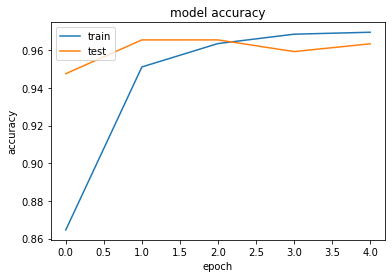

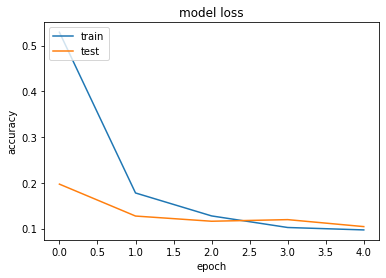

In [18]:
# l'hist pour accuracy
plt.plot(hist_1.history['accuracy'])
plt.plot(hist_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc = 'upper left')
plt.show()

#l'hist pour la perte
plt.plot(hist_1.history['loss'])
plt.plot(hist_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc = 'upper left')
plt.show()

In [26]:
data_gen = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.5, 
    zoom_range=0.4, 
    rescale=1./255,
    vertical_flip=True, 
    validation_split=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

TRN_AUGMENTED = os.path.join(PATH , 'Trn_Augmented_Images')
TST_AUGMENTED = os.path.join(PATH , 'Tst_Augmented_Images')

In [27]:
test_generator = data_gen.flow_from_directory(
        PATH,
        target_size=(img_rows, img_cols),
        batch_size=32,
        class_mode='categorical',
        color_mode='rgb', 
        shuffle=True, 
        seed=None, 
        subset="validation")

Found 1377 images belonging to 8 classes.


In [29]:
test_generator.class_indices

{'airplane': 0,
 'car': 1,
 'cat': 2,
 'dog': 3,
 'flower': 4,
 'fruit': 5,
 'motorbike': 6,
 'person': 7}

7


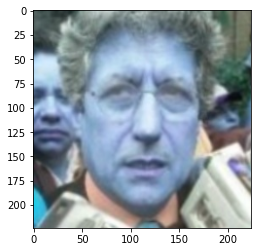

6


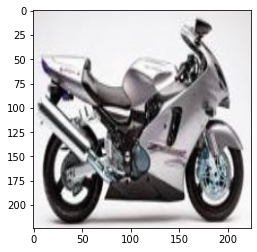

4


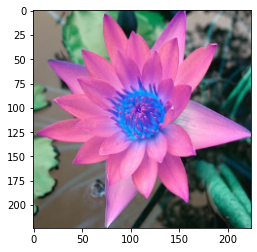

2


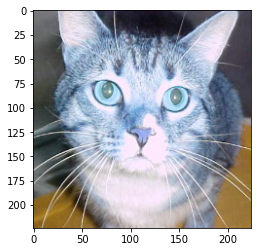

3


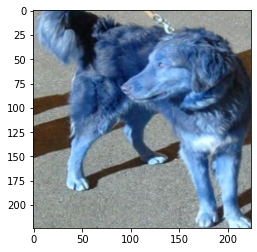

7


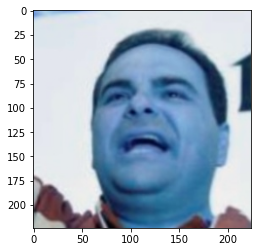

7


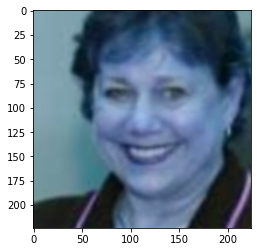

4


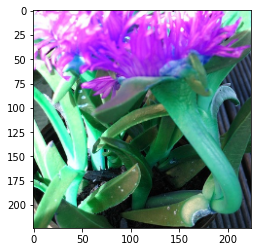

3


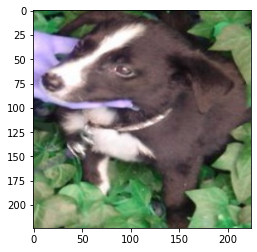

7


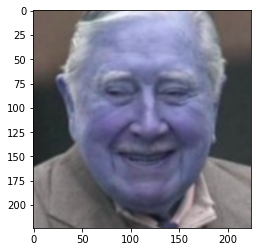

4


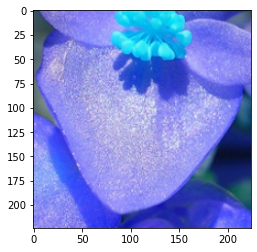

3


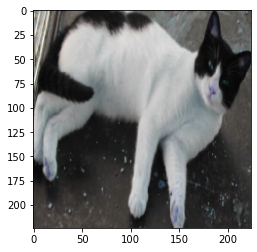

5


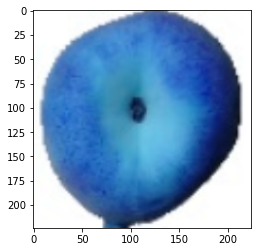

1


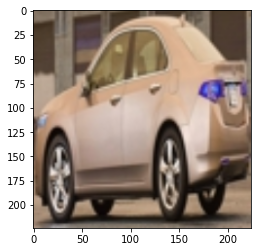

1


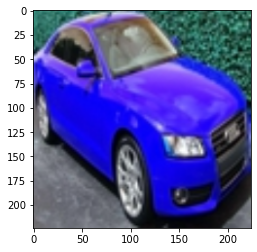

1


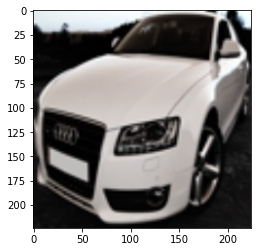

1


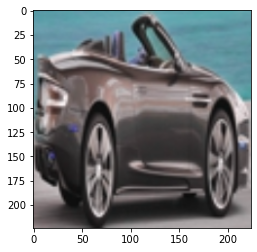

1


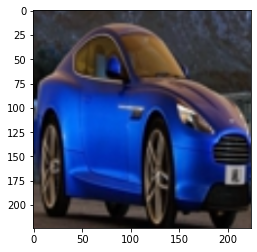

4


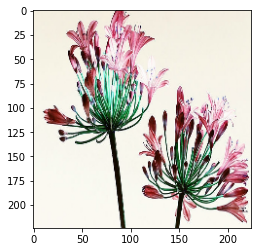

5


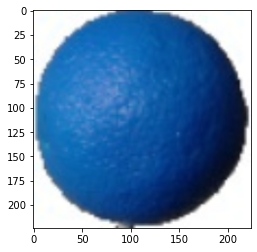

5


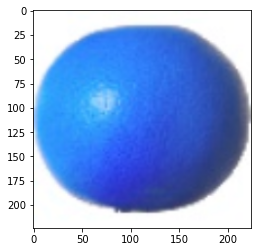

0


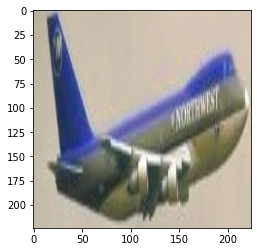

7


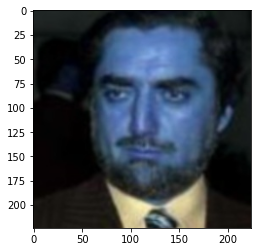

7


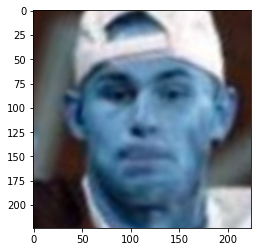

2


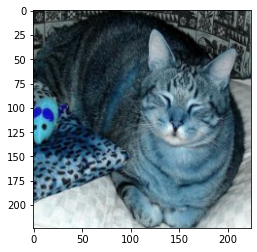

4


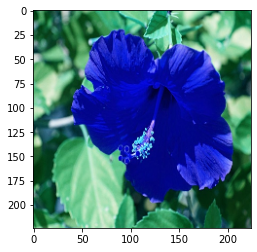

4


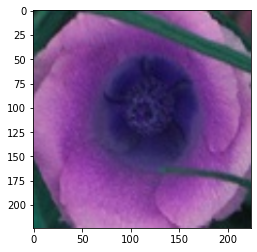

1


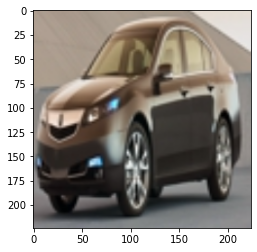

3


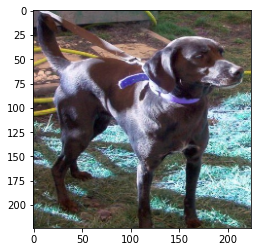

In [39]:

for i in range(1,30):
    plt.imshow(X_test[i])
    #plt.imshow(np.fliplr(X_test[i]))
    print(y_test_pred[i])
    plt.show(block=False)
    
